In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 22.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 20.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/mobilenetv2/lbp/mit_indoor/mit_indoor_lbp_above.csv")
train_df2 = pd.read_csv("files/mobilenetv2/lbp/mit_indoor/mit_indoor_lbp_below.csv")

In [5]:
print(train_df2)

                                       file          label
0     airportinside/airport_inside_0604.jpg  airportinside
1     airportinside/airport_inside_0514.jpg  airportinside
2     airportinside/airport_inside_0499.jpg  airportinside
3     airportinside/airport_inside_0102.jpg  airportinside
4     airportinside/airport_inside_0076.jpg  airportinside
...                                     ...            ...
3001                cloister/14claustro.jpg       cloister
3002         cloister/claustro_romanico.jpg       cloister
3003       cloister/96847179_5961f50b85.jpg       cloister
3004                  cloister/IMG_0432.jpg       cloister
3005                 cloister/cloister5.jpg       cloister

[3006 rows x 2 columns]


In [6]:
##df1 = train_df.drop(range(1800,2156))
##df2 = train_df2.drop(range(1800,2380))

In [7]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [8]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="mit_indoor_67/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="mit_indoor_67/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 1224 non-validated image filenames belonging to 15 classes.
Found 2405 non-validated image filenames belonging to 15 classes.


In [9]:
model_name = mobilenetv2
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
model_t.trainable = False
model_t2.trainable = False

In [11]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [12]:
#model classifier topup
#reg=0.001
model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(15, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(15, activation='softmax'))

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [14]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=150, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=150, verbose=1)


Epoch 1/150
153/153 [==============================] - 63s 343ms/step - loss: 2.5376 - accuracy: 0.2733 - precision: 0.4626 - recall: 0.1214
Epoch 2/150
153/153 [==============================] - 28s 183ms/step - loss: 1.5095 - accuracy: 0.5606 - precision: 0.7757 - recall: 0.3233
Epoch 3/150
153/153 [==============================] - 29s 191ms/step - loss: 1.3013 - accuracy: 0.6205 - precision: 0.8217 - recall: 0.3776
Epoch 4/150
153/153 [==============================] - 28s 184ms/step - loss: 1.2529 - accuracy: 0.6370 - precision: 0.8289 - recall: 0.4379
Epoch 5/150
153/153 [==============================] - 28s 185ms/step - loss: 1.1128 - accuracy: 0.6838 - precision: 0.8678 - recall: 0.4550
Epoch 6/150
153/153 [==============================] - 28s 184ms/step - loss: 1.0334 - accuracy: 0.7181 - precision: 0.8656 - recall: 0.4891
Epoch 7/150
153/153 [==============================] - 28s 184ms/step - loss: 0.9729 - accuracy: 0.7347 - precision: 0.8738 - recall: 0.5215
Epoch 8/150
1

153/153 [==============================] - 28s 185ms/step - loss: 0.3836 - accuracy: 0.8941 - precision: 0.9314 - recall: 0.8206
Epoch 59/150
153/153 [==============================] - 28s 181ms/step - loss: 0.4011 - accuracy: 0.9076 - precision: 0.9294 - recall: 0.8463
Epoch 60/150
153/153 [==============================] - 28s 183ms/step - loss: 0.3961 - accuracy: 0.9029 - precision: 0.9369 - recall: 0.8312
Epoch 61/150
153/153 [==============================] - 29s 187ms/step - loss: 0.3810 - accuracy: 0.8888 - precision: 0.9380 - recall: 0.8322
Epoch 62/150
153/153 [==============================] - 28s 183ms/step - loss: 0.3373 - accuracy: 0.9129 - precision: 0.9542 - recall: 0.8612
Epoch 63/150
153/153 [==============================] - 28s 184ms/step - loss: 0.4036 - accuracy: 0.8982 - precision: 0.9383 - recall: 0.8206
Epoch 64/150
153/153 [==============================] - 28s 184ms/step - loss: 0.3965 - accuracy: 0.8923 - precision: 0.9346 - recall: 0.8106
Epoch 65/150
153/15

153/153 [==============================] - 29s 186ms/step - loss: 0.2504 - accuracy: 0.9252 - precision: 0.9512 - recall: 0.8987
Epoch 116/150
153/153 [==============================] - 28s 184ms/step - loss: 0.2350 - accuracy: 0.9313 - precision: 0.9515 - recall: 0.8991
Epoch 117/150
153/153 [==============================] - 28s 185ms/step - loss: 0.2616 - accuracy: 0.9370 - precision: 0.9517 - recall: 0.9078
Epoch 118/150
153/153 [==============================] - 28s 183ms/step - loss: 0.2748 - accuracy: 0.9253 - precision: 0.9504 - recall: 0.8849
Epoch 119/150
153/153 [==============================] - 29s 185ms/step - loss: 0.2611 - accuracy: 0.9318 - precision: 0.9588 - recall: 0.8906
Epoch 120/150
153/153 [==============================] - 29s 187ms/step - loss: 0.2959 - accuracy: 0.9156 - precision: 0.9431 - recall: 0.8922
Epoch 121/150
153/153 [==============================] - 28s 180ms/step - loss: 0.2538 - accuracy: 0.9250 - precision: 0.9435 - recall: 0.8964
Epoch 122/150

301/301 [==============================] - 49s 162ms/step - loss: 0.5890 - accuracy: 0.8353 - precision: 0.9136 - recall: 0.7523
Epoch 23/150
301/301 [==============================] - 49s 163ms/step - loss: 0.5833 - accuracy: 0.8246 - precision: 0.8820 - recall: 0.7392
Epoch 24/150
301/301 [==============================] - 49s 163ms/step - loss: 0.5236 - accuracy: 0.8544 - precision: 0.9181 - recall: 0.7666
Epoch 25/150
301/301 [==============================] - 49s 163ms/step - loss: 0.5797 - accuracy: 0.8295 - precision: 0.8999 - recall: 0.7388
Epoch 26/150
301/301 [==============================] - 49s 162ms/step - loss: 0.5777 - accuracy: 0.8306 - precision: 0.9022 - recall: 0.7533
Epoch 27/150
301/301 [==============================] - 50s 165ms/step - loss: 0.5633 - accuracy: 0.8467 - precision: 0.8991 - recall: 0.7639
Epoch 28/150
301/301 [==============================] - 50s 165ms/step - loss: 0.4958 - accuracy: 0.8543 - precision: 0.9055 - recall: 0.7896
Epoch 29/150
301/30

301/301 [==============================] - 51s 168ms/step - loss: 0.3368 - accuracy: 0.9053 - precision: 0.9375 - recall: 0.8575
Epoch 80/150
301/301 [==============================] - 51s 169ms/step - loss: 0.3198 - accuracy: 0.9095 - precision: 0.9380 - recall: 0.8693
Epoch 81/150
301/301 [==============================] - 50s 167ms/step - loss: 0.3712 - accuracy: 0.8957 - precision: 0.9298 - recall: 0.8492
Epoch 82/150
301/301 [==============================] - 51s 170ms/step - loss: 0.3238 - accuracy: 0.9044 - precision: 0.9439 - recall: 0.8624
Epoch 83/150
301/301 [==============================] - 50s 166ms/step - loss: 0.3401 - accuracy: 0.8958 - precision: 0.9337 - recall: 0.8545
Epoch 84/150
301/301 [==============================] - 50s 166ms/step - loss: 0.3500 - accuracy: 0.8967 - precision: 0.9293 - recall: 0.8622
Epoch 85/150
301/301 [==============================] - 50s 167ms/step - loss: 0.3391 - accuracy: 0.9023 - precision: 0.9325 - recall: 0.8671
Epoch 86/150
301/30

301/301 [==============================] - 51s 170ms/step - loss: 0.2913 - accuracy: 0.9133 - precision: 0.9314 - recall: 0.8887
Epoch 137/150
301/301 [==============================] - 50s 166ms/step - loss: 0.2725 - accuracy: 0.9140 - precision: 0.9396 - recall: 0.8933
Epoch 138/150
301/301 [==============================] - 51s 169ms/step - loss: 0.2558 - accuracy: 0.9218 - precision: 0.9415 - recall: 0.8982
Epoch 139/150
301/301 [==============================] - 51s 170ms/step - loss: 0.2675 - accuracy: 0.9236 - precision: 0.9504 - recall: 0.8956
Epoch 140/150
301/301 [==============================] - 51s 170ms/step - loss: 0.2628 - accuracy: 0.9223 - precision: 0.9395 - recall: 0.8929
Epoch 141/150
301/301 [==============================] - 51s 168ms/step - loss: 0.2371 - accuracy: 0.9329 - precision: 0.9490 - recall: 0.9037
Epoch 142/150
301/301 [==============================] - 51s 171ms/step - loss: 0.2697 - accuracy: 0.9097 - precision: 0.9447 - recall: 0.8923
Epoch 143/150

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


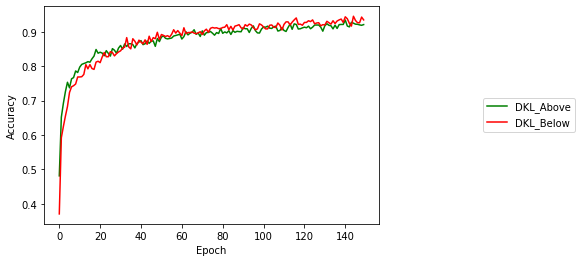

In [20]:
fig1 = plt.figure()


plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
#plt.title('Caltech 256')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_lbp_DKL_accuracy_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


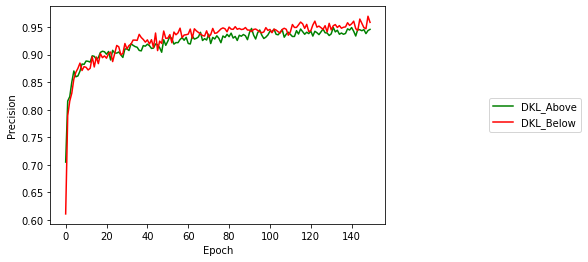

In [19]:
fig1 = plt.figure()


plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')
#plt.title('Caltech 256')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_lbp_DKL_precision_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


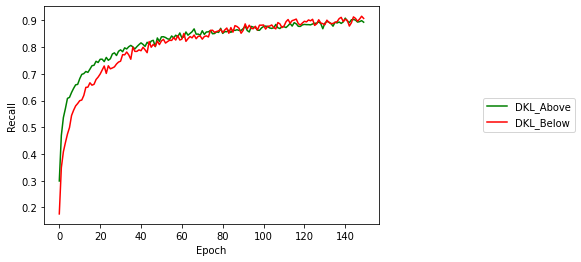

In [18]:
fig1 = plt.figure()

plt.plot(history2.history['recall'], color='g')
plt.plot(history.history['recall'], color='r')
#plt.title('Caltech 256')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_lbp_DKL_recall_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 